In [35]:
import json
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import requests


In [37]:
import requests

def fetch_json_from_url(url, disable_ssl_verification=False):
  try:
    response = requests.get(url, verify=not disable_ssl_verification)
    response.raise_for_status()  # Raise an error for HTTP errors
    return response.json()
  except requests.exceptions.RequestException as e:
      print(f"Error fetching data from {url}: {e}")
      return None

    # URLs for the JSON data
current_test_url = "https://jsonkeeper.com/b/LLQT"
overall_test_url = "https://api.jsonserve.com/rJvd7g"
past_tests_url = "https://api.jsonserve.com/XgAgFJ"
# Fetch data from the URLs
current_test = fetch_json_from_url(current_test_url, disable_ssl_verification= True)
overall_test = fetch_json_from_url(overall_test_url, )
past_tests = fetch_json_from_url(past_tests_url, )
# Exit if any data fails to load
if not current_test or not overall_test or not past_tests:
  print("Failed to fetch all required data. Exiting...")
  exit()

print("Successfully fetched all required data!")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jsonkeeper.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Successfully fetched all required data!


In [38]:
def calculate_accuracy(correct_answers, total_questions):
    """Calculate accuracy percentage."""
    return (correct_answers / total_questions) * 100

In [39]:
def find_weak_topics(past_tests_data):
  """Identify weak topics based on incorrect answers."""
  topic_mistakes = {}

  for test in past_tests_data:
    quiz_title = test["quiz"]["title"]
    incorrect_answers = test["incorrect_answers"]
    total_questions = test["total_questions"]

    if quiz_title not in topic_mistakes:
      topic_mistakes[quiz_title] = {"incorrect": 0, "total": 0}

    topic_mistakes[quiz_title]["incorrect"] += incorrect_answers
    topic_mistakes[quiz_title]["total"] += total_questions

    # Calculate mistake percentage per topic
  for topic, stats in topic_mistakes.items():
    stats["mistake_percentage"] = (stats["incorrect"] / stats["total"]) * 100

    # Sort topics by highest mistake percentage
  return sorted(topic_mistakes.items(), key=lambda x: x[1]["mistake_percentage"], reverse=True)

In [40]:
def analyze_trends(past_tests_data):
  """Analyze improvement trends in accuracy and speed over time."""
  trends = {"accuracy": [], "speed": [], "timestamps": []}

  for test in past_tests_data:
    accuracy = float(test["accuracy"].replace("%", ""))
    speed = float(test["speed"])
    timestamp = datetime.strptime(test["submitted_at"], "%Y-%m-%dT%H:%M:%S.%f%z")

    trends["accuracy"].append(accuracy)
    trends["speed"].append(speed)
    trends["timestamps"].append(timestamp)

  return trends

In [41]:
def generate_recommendations(overall_test_data, past_tests_data):
  """Generate personalized recommendations based on data."""
  weak_topics = find_weak_topics(past_tests_data)
  recommendations = []

  if weak_topics:
  # Focus on the top weak topic
    weakest_topic = weak_topics[0]
    topic_name = weakest_topic[0]
    mistake_percentage = weakest_topic[1]["mistake_percentage"]

    recommendations.append(
      f"Focus on the topic '{topic_name}', where you made mistakes in "
      f"{mistake_percentage:.2f}% of the questions."
  )
   # Analyze trends
  trends = analyze_trends(past_tests_data)
  if len(trends["accuracy"]) > 1:
        accuracy_improvement = trends["accuracy"][-1] - trends["accuracy"][0]
        speed_improvement = trends["speed"][-1] - trends["speed"][0]

  if accuracy_improvement > 0:
        recommendations.append(
          f"Your accuracy has improved by {accuracy_improvement:.2f}% over recent tests. Keep it up!"
          )
  else:
        recommendations.append("Consider reviewing past mistakes to improve your accuracy.")

  if speed_improvement > 0:
        recommendations.append(
          f"Your speed has improved by {speed_improvement:.2f} points. You're getting faster!"
          )

  return recommendations

In [44]:
def extract_features(past_tests_data):
  """Prepare data for ML modeling."""
  features = []
  targets = []

  for test in past_tests_data:
    accuracy = float(test["accuracy"].replace("%", ""))
    speed = float(test["speed"])
    total_questions = test["total_questions"]
    correct_answers = test["correct_answers"]
    incorrect_answers = test["incorrect_answers"]

    # Input features: Speed, Total Questions
    features.append([speed, total_questions])
    # Target: Accuracy
    targets.append(accuracy)

  return np.array(features), np.array(targets)

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
features, targets = extract_features(past_tests)
from datetime import datetime
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Build and Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and Evaluate the Model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Analysis Results
overall_accuracy = calculate_accuracy(
    overall_test["correct_answers"], overall_test["total_questions"]
)
weak_topics = find_weak_topics(past_tests)
recommendations = generate_recommendations(overall_test, past_tests)


In [47]:
# Output Results
print("Overall Test Accuracy:", f"{overall_accuracy:.2f}%")
print("\nWeak Topics:")
for topic, stats in weak_topics:
  print(f"- {topic}: {stats['mistake_percentage']:.2f}% mistakes")

print("\nPersonalized Recommendations:")
for rec in recommendations:
  print(f"- {rec}")

print("\nModel Performance:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Overall Test Accuracy: 6.25%

Weak Topics:
- Reproduction: 22.92% mistakes
- Human Physiology PYQ: 14.49% mistakes
- PRINCIPLES OF INHERITANCE AND VARIATION PYQ: 11.86% mistakes
- Human Physiology (15): 8.00% mistakes
- REPRODUCTIVE HEALTH PYQ: 6.82% mistakes
- HUMAN HEALTH AND DISEASE PYQ: 4.88% mistakes
- Human Physiology (14): 3.00% mistakes
- MICROBES IN HUMAN WELFARE  PYQ: 0.00% mistakes

Personalized Recommendations:
- Focus on the topic 'Reproduction', where you made mistakes in 22.92% of the questions.
- Consider reviewing past mistakes to improve your accuracy.

Model Performance:
Mean Absolute Error: 20.49
R^2 Score: -10.02


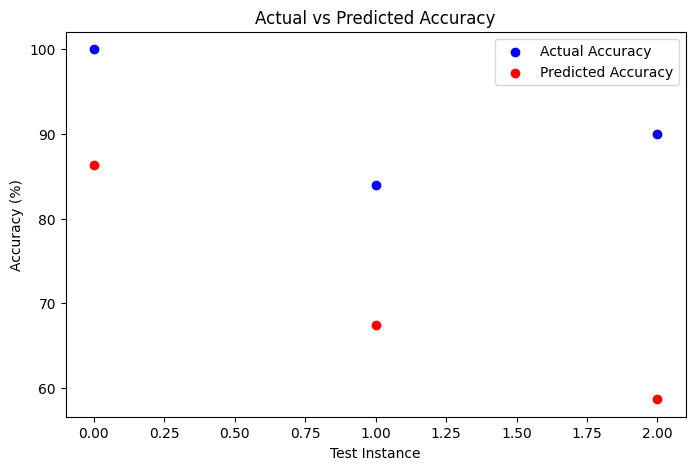

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.scatter(range(len(y_test)), y_test, color="blue", label="Actual Accuracy")
plt.scatter(range(len(y_pred)), y_pred, color="red", label="Predicted Accuracy")
plt.title("Actual vs Predicted Accuracy")
plt.xlabel("Test Instance")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

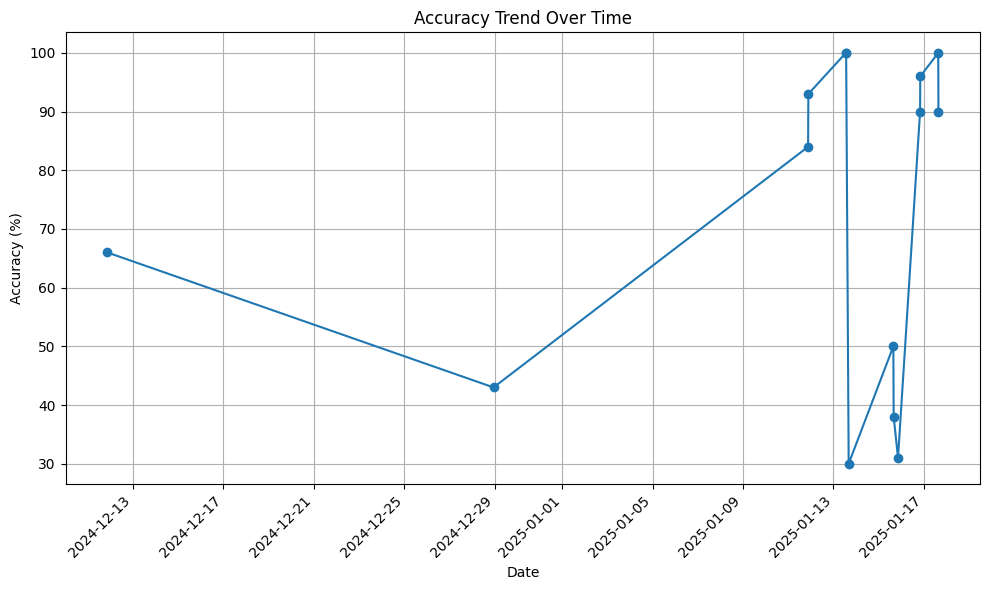

In [49]:
import matplotlib.pyplot as plt

trends = analyze_trends(past_tests)  # Assuming 'analyze_trends' function is defined

plt.figure(figsize=(10, 6))
plt.plot(trends["timestamps"], trends["accuracy"], marker='o', linestyle='-')
plt.title("Accuracy Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

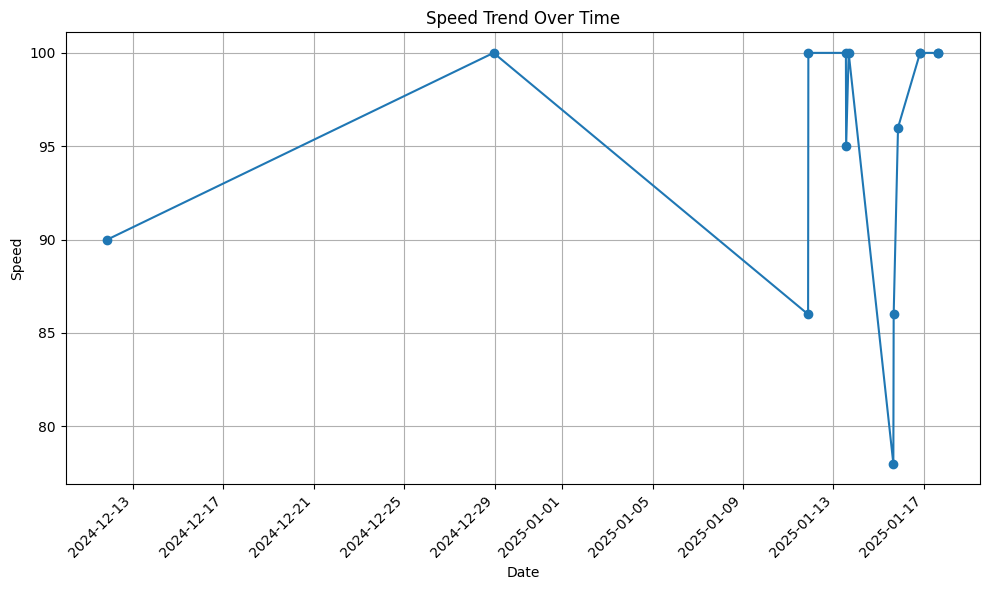

In [50]:
import matplotlib.pyplot as plt

trends = analyze_trends(past_tests)  # Assuming 'analyze_trends' function is defined

plt.figure(figsize=(10, 6))
plt.plot(trends["timestamps"], trends["speed"], marker='o', linestyle='-')
plt.title("Speed Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Speed")
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

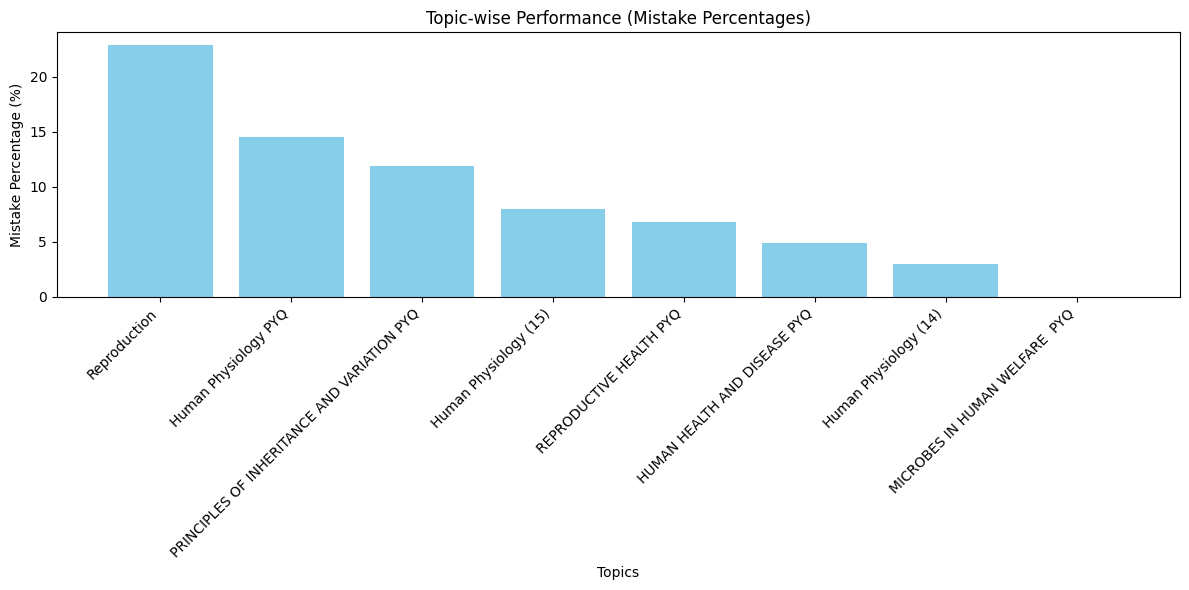

In [51]:
import matplotlib.pyplot as plt
import numpy as np

weak_topics = find_weak_topics(past_tests)  # Assuming 'find_weak_topics' function is defined

topics = [topic[0] for topic in weak_topics]
mistake_percentages = [topic[1]["mistake_percentage"] for topic in weak_topics]

plt.figure(figsize=(12, 6))
plt.bar(topics, mistake_percentages, color='skyblue')
plt.title("Topic-wise Performance (Mistake Percentages)")
plt.xlabel("Topics")
plt.ylabel("Mistake Percentage (%)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

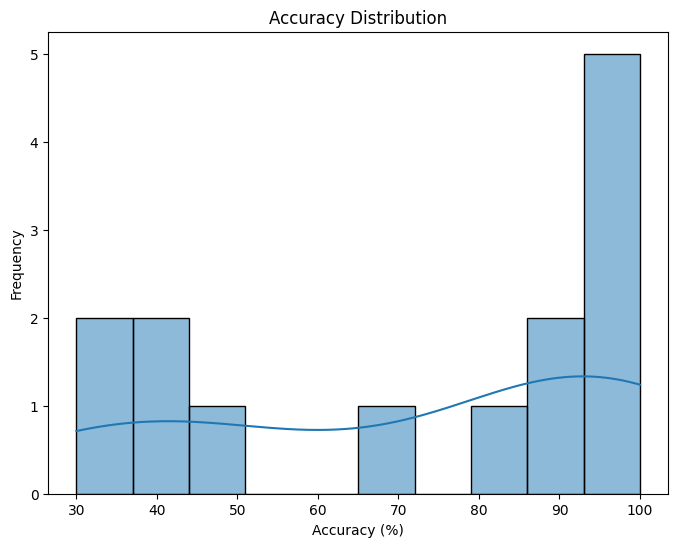

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

trends = analyze_trends(past_tests)  # Assuming 'analyze_trends' function is defined

plt.figure(figsize=(8, 6))
sns.histplot(trends["accuracy"], bins=10, kde=True)
plt.title("Accuracy Distribution")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

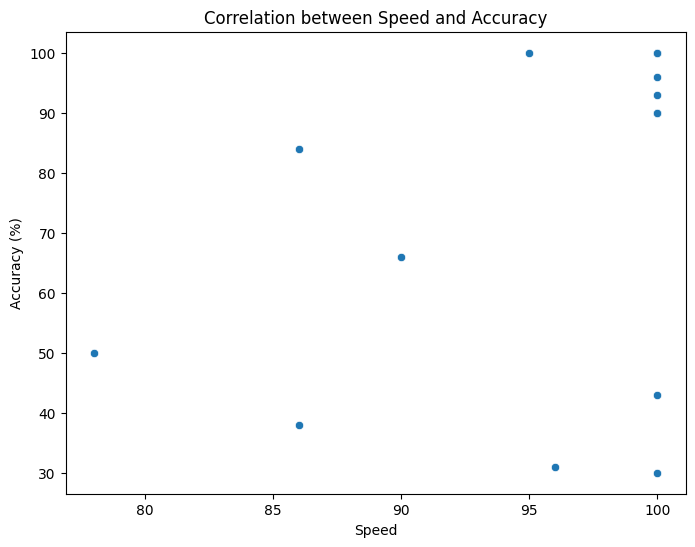

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

trends = analyze_trends(past_tests)  # Assuming 'analyze_trends' function is defined

plt.figure(figsize=(8, 6))
sns.scatterplot(x=trends["speed"], y=trends["accuracy"])
plt.title("Correlation between Speed and Accuracy")
plt.xlabel("Speed")
plt.ylabel("Accuracy (%)")
plt.show()

In [54]:
def assign_attributes(current_test_data, past_tests_data):
    """Assigns attributes to the student based on their performance."""
    attributes = []

    # Fast Learner
    weak_topics = find_weak_topics(past_tests_data)
    if weak_topics:
        weakest_topic = weak_topics[0][0]  # Get the weakest topic
        # Check if the weakest topic is now mastered in the current test
        current_topic_performance = next(
            (
                test
                for test in current_test_data
                if test["quiz"]["title"] == weakest_topic
            ),
            None,
        )
        if current_topic_performance and current_topic_performance[
            "incorrect_answers"
        ] == 0:
            attributes.append("Fast Learner")

    # Perfectionist
    if current_test_data["incorrect_answers"] / current_test_data[
        "total_questions"
    ] < 0.1:
        attributes.append("Perfectionist")

    # Completionist
    if current_test_data["total_questions"] - current_test_data[
        "correct_answers"
    ] - current_test_data["incorrect_answers"] == 0:
        attributes.append("Completionist")

    return attributes

In [55]:
def assign_attributes(current_test_data, past_tests_data):
    """Assigns attributes to the student based on their performance."""
    attributes = []

    # Fast Learner
    weak_topics = find_weak_topics(past_tests_data)
    if weak_topics:
        weakest_topic = weak_topics[0][0]  # Get the weakest topic
        # Check if the weakest topic is now mastered in the current test
        # Wrap current_test_data in a list if it's a dictionary to ensure it's iterable
        iterable_current_test_data = current_test_data if isinstance(current_test_data, list) else [current_test_data]
        current_topic_performance = next(
            (
                test
                for test in iterable_current_test_data  # Iterate through the wrapped data
                if test.get("quiz", {}).get("title") == weakest_topic  # Use get to safely access nested keys
            ),
            None,
        )
        if current_topic_performance and current_topic_performance.get("incorrect_answers", 0) == 0:
            attributes.append("Fast Learner")

    # Perfectionist
    if current_test_data.get("incorrect_answers", 0) / current_test_data.get("total_questions", 1) < 0.1:  # Use get with default values
        attributes.append("Perfectionist")

    # Completionist
    if current_test_data.get("total_questions", 0) - current_test_data.get("correct_answers", 0) - current_test_data.get("incorrect_answers", 0) == 0:  # Use get with default values
        attributes.append("Completionist")

    return attributes

In [57]:
current_test = fetch_json_from_url(current_test_url, disable_ssl_verification=True)  # Fetch current test data
past_tests = fetch_json_from_url(past_tests_url)  # Fetch past test data

student_attributes = assign_attributes(current_test, past_tests)
print("Student Attributes:", student_attributes)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jsonkeeper.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Student Attributes: ['Perfectionist', 'Completionist']
